In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

PATH = 'data/decoupling.csv'

thr_high: 0.9783455437867415
thr_low: -1.2381825621849338


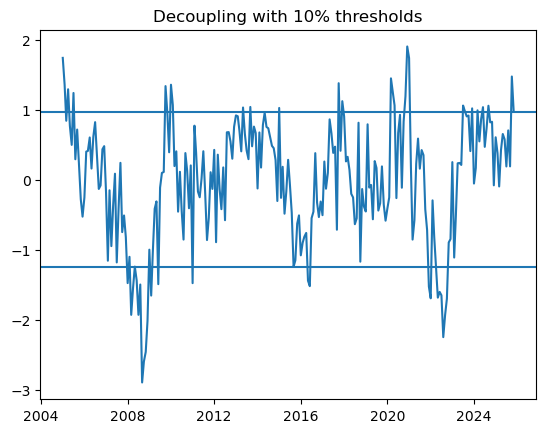

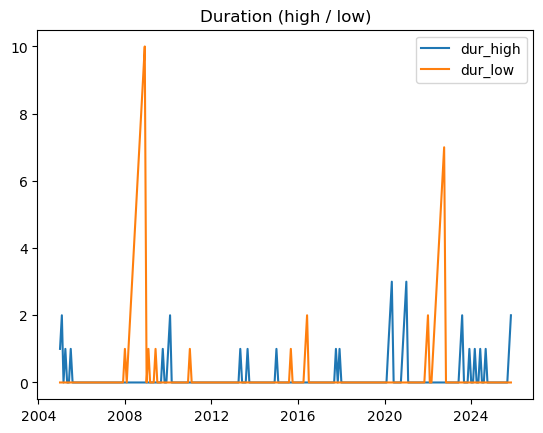

In [13]:

# ===== load =====
df = pd.read_csv(PATH)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").drop_duplicates("date", keep="last")
df = df.set_index("date")

df["D"] = pd.to_numeric(df["gap"], errors="coerce")
df = df.dropna(subset=["D"])

# ===== threshold =====
thr_high = df["D"].quantile(0.9)
thr_low = df["D"].quantile(0.1)

print("thr_high:", thr_high)
print("thr_low:", thr_low)

df["high_regime"] = df["D"] >= thr_high
df["low_regime"] = df["D"] <= thr_low

# ===== duration 계산 =====
dur_high = []
dur_low = []

count_h = 0
count_l = 0

for h, l in zip(df["high_regime"], df["low_regime"]):
    if h:
        count_h += 1
    else:
        count_h = 0
    dur_high.append(count_h)

    if l:
        count_l += 1
    else:
        count_l = 0
    dur_low.append(count_l)

df["dur_high"] = dur_high
df["dur_low"] = dur_low

# ===== plot =====
plt.figure()
plt.plot(df.index, df["D"])
plt.axhline(thr_high)
plt.axhline(thr_low)
plt.title("Decoupling with 10% thresholds")
plt.show()

plt.figure()
plt.plot(df.index, df["dur_high"], label="dur_high")
plt.plot(df.index, df["dur_low"], label="dur_low")
plt.legend()
plt.title("Duration (high / low)")
plt.show()


In [14]:
# ===== 금융 수익률 =====
df["fin_ret"] = df["fin_index"].diff()

# ===== 급락 정의 (하위 10%) =====
crash_thr = df["fin_ret"].quantile(0.1)
df["crash"] = df["fin_ret"] <= crash_thr

print("crash count:", df["crash"].sum())


crash count: 25


In [15]:
# ===== 향후 3개월 내 급락 여부 =====
h = 3

future_crash = []

for i in range(len(df)):
    if i + h < len(df):
        future = df["crash"].iloc[i+1:i+1+h]
        future_crash.append(future.any())
    else:
        future_crash.append(False)

df["future_crash_3m"] = future_crash


In [16]:
# ===== 확률 계산 =====
p_high = df.loc[df["high_regime"], "future_crash_3m"].mean()
p_normal = df.loc[~df["high_regime"], "future_crash_3m"].mean()

print("P(crash | high_regime):", p_high)
print("P(crash | normal):", p_normal)


P(crash | high_regime): 0.19230769230769232
P(crash | normal): 0.24444444444444444


In [17]:
df["dur_bucket"] = pd.cut(df["dur_high"], bins=[0,1,3,6,100])

print(
    df.groupby("dur_bucket")["future_crash_3m"].mean()
)


dur_bucket
(0, 1]      0.222222
(1, 3]      0.125000
(3, 6]           NaN
(6, 100]         NaN
Name: future_crash_3m, dtype: float64


C:\Users\may670\AppData\Local\Temp\ipykernel_11904\149782014.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("dur_bucket")["future_crash_3m"].mean()
